In [ ]:
from google.colab import files
uploaded = files.upload()

Saving sales_dataset.csv to sales_dataset.csv


**Imports**

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from xgboost import plot_importance
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import StackingRegressor
from sklearn.feature_selection import RFE
from sklearn.linear_model import Ridge
import pickle
from plotly.subplots import make_subplots

Loading the data

In [ ]:
df = pd.read_csv("sales_dataset.csv")
df

,Region,Country,Item Type,Sales Channel,Order Priority,Order Date,Order ID,Ship Date,Units Sold,Unit Price,Unit Cost,Total Revenue,Total Cost,Total Profit
0,Sub-Saharan Africa,South Africa,Fruits,Offline,M,2012-07-27,443368995,2012-07-28,611265,38.26,12.67,23386998.90,7744727.55,15642271.35
1,Middle East and North Africa,Morocco,Clothes,Online,M,2013-09-14,667593514,2013-10-19,545518,145.65,79.81,79454696.70,43537791.58,35916905.12
2,Australia and Oceania,Papua New Guinea,Meat,Offline,M,2015-05-15,940995585,2015-06-04,326908,186.66,94.10,61020647.28,30762042.80,30258604.48
3,Sub-Saharan Africa,Djibouti,Clothes,Offline,H,2017-05-17,880811536,2017-07-02,431659,144.86,66.93,62530122.74,28890936.87,33639185.87
4,Europe,Slovakia,Beverages,Offline,L,2016-10-26,174590194,2016-12-04,625973,15.86,6.30,9927931.78,3943629.90,5984301.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994594,Sub-Saharan Africa,Senegal,Baby Food,Offline,L,2010-11-06,575470578,2010-12-11,317898,80.07,28.90,25454092.86,9187252.20,16266840.66
994595,Central America and the Caribbean,Panama,Office Supplies,Offline,C,2015-01-12,766942107,2015-03-01,363273,106.49,43.83,38684941.77,15922255.59,22762686.18
994596,Europe,Norway,Office Supplies,Online,M,2011-10-25,685472047,2011-12-05,367562,101.90,46.38,37454567.80,17047525.56,20407042.24
994597,Europe,Montenegro,Beverages,Offline,M,2010-10-31,946734225,2010-12-08,663167,15.08,6.87,10000558.36,4555957.29,5444601.07


In [ ]:
df.columns

Index(['Region', 'Country', 'Item Type', 'Sales Channel', 'Order Priority',
       'Order Date', 'Order ID', 'Ship Date', 'Units Sold', 'Unit Price',
       'Unit Cost', 'Total Revenue', 'Total Cost', 'Total Profit'],
      dtype='object')

EDA

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 994599 entries, 0 to 994598
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Region          994599 non-null  object 
 1   Country         994599 non-null  object 
 2   Item Type       994599 non-null  object 
 3   Sales Channel   994599 non-null  object 
 4   Order Priority  994599 non-null  object 
 5   Order Date      994599 non-null  object 
 6   Order ID        994599 non-null  int64  
 7   Ship Date       994599 non-null  object 
 8   Units Sold      994599 non-null  int64  
 9   Unit Price      994599 non-null  float64
 10  Unit Cost       994599 non-null  float64
 11  Total Revenue   994599 non-null  float64
 12  Total Cost      994599 non-null  float64
 13  Total Profit    994599 non-null  float64
dtypes: float64(5), int64(2), object(7)
memory usage: 106.2+ MB


In [ ]:
df.describe()

,Order ID,Units Sold,Unit Price,Unit Cost,Total Revenue,Total Cost,Total Profit
count,9.945990e+05,9.945990e+05,994599.000000,994599.000000,9.945990e+05,9.945990e+05,9.945990e+05
mean,5.493688e+08,4.477692e+05,92.474857,46.323549,3.609370e+07,1.773078e+07,1.836292e+07
std,2.599414e+08,1.508199e+05,80.551447,50.328235,2.969549e+07,1.875209e+07,1.170984e+07
min,1.000012e+08,9.300100e+04,13.500000,3.830000,2.888710e+06,7.636766e+05,1.850556e+06
25%,3.239774e+08,3.439005e+05,27.270000,6.290000,1.400434e+07,3.785686e+06,1.006361e+07
50%,5.487189e+08,4.144380e+05,74.650000,33.120000,2.660794e+07,1.145205e+07,1.464189e+07
75%,7.746139e+08,5.144585e+05,109.970000,66.680000,4.680453e+07,2.462405e+07,2.359062e+07
max,9.999999e+08,1.759186e+06,330.000000,227.310000,2.278949e+08,1.432110e+08,1.091599e+08


In [ ]:
df.describe(include='object')

,Region,Country,Item Type,Sales Channel,Order Priority,Order Date,Ship Date
count,994599,994599,994599,994599,994599,994599,994599
unique,7,184,12,2,4,2767,2817
top,Sub-Saharan Africa,Panama,Fruits,Offline,C,2016-11-25,2015-08-14
freq,259953,5606,83111,497576,249001,426,419


Feature Enginnering

In [ ]:
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Ship Date'] = pd.to_datetime(df['Ship Date'])

In [ ]:
df = df.sort_values('Order Date').reset_index(drop=True)

df['Year'] = df['Order Date'].dt.year
df['Month'] = df['Order Date'].dt.month
df['DayOfWeek'] = df['Order Date'].dt.dayofweek
df['Quarter'] = df['Order Date'].dt.quarter
df['DayOfMonth'] = df['Order Date'].dt.day
df['WeekOfYear'] = df['Order Date'].dt.isocalendar().week

df['Shipping_Days'] = (df['Ship Date'] - df['Order Date']).dt.days

In [ ]:
for window in [7, 30]:
    df[f'Rolling_{window}d_Avg_Revenue'] = df.groupby('Region')['Total Revenue'].transform(
        lambda x: x.rolling(window, min_periods=1).mean())
    df[f'Rolling_{window}d_Avg_Units'] = df.groupby('Region')['Units Sold'].transform(
        lambda x: x.rolling(window, min_periods=1).mean())

In [ ]:
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].astype('category')

df

,Region,Country,Item Type,Sales Channel,Order Priority,Order Date,Order ID,Ship Date,Units Sold,Unit Price,...,Month,DayOfWeek,Quarter,DayOfMonth,WeekOfYear,Shipping_Days,Rolling_7d_Avg_Revenue,Rolling_7d_Avg_Units,Rolling_30d_Avg_Revenue,Rolling_30d_Avg_Units
0,Australia and Oceania,Federated States of Micronesia,Household,Online,H,2010-01-01,483460080,2010-01-17,374104,271.18,...,1,4,1,1,53,16,1.014495e+08,374104.000000,1.014495e+08,374104.000000
1,Sub-Saharan Africa,Benin,Fruits,Offline,M,2010-01-01,745230376,2010-01-04,746270,38.56,...,1,4,1,1,53,3,2.877617e+07,746270.000000,2.877617e+07,746270.000000
2,Asia,Singapore,Personal Care,Online,M,2010-01-01,871963250,2010-02-07,366317,65.99,...,1,4,1,1,53,37,2.417326e+07,366317.000000,2.417326e+07,366317.000000
3,Europe,Russia,Clothes,Online,H,2010-01-01,836816442,2010-02-19,482837,153.20,...,1,4,1,1,53,49,7.397063e+07,482837.000000,7.397063e+07,482837.000000
4,Europe,Latvia,Cosmetics,Offline,L,2010-01-01,853307521,2010-01-19,404100,92.21,...,1,4,1,1,53,18,5.561634e+07,443468.500000,5.561634e+07,443468.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994594,Asia,Indonesia,Baby Food,Online,L,2017-07-29,666396176,2017-08-03,282062,78.62,...,7,5,3,29,30,5,2.760261e+07,476843.000000,2.880111e+07,471857.300000
994595,Asia,Vietnam,Snacks,Offline,L,2017-07-29,938753688,2017-09-07,596919,18.43,...,7,5,3,29,30,40,2.106009e+07,519447.142857,2.862027e+07,484986.433333
994596,Asia,Bhutan,Clothes,Online,C,2017-07-29,992792260,2017-09-14,409409,137.54,...,7,5,3,29,30,47,2.542115e+07,481337.285714,3.009490e+07,478544.633333
994597,Asia,Taiwan,Personal Care,Offline,C,2017-07-29,365149772,2017-08-29,318815,73.91,...,7,5,3,29,30,31,2.507939e+07,476060.000000,3.055795e+07,468002.933333


Handling Duplicates

In [ ]:
df.duplicated().sum()

np.int64(0)

In [ ]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

np.int64(0)

**Visualization**

In [ ]:
sales_trend = df.groupby('Year')['Total Revenue'].sum().reset_index()

fig = px.line(
    sales_trend,
    x='Year',
    y='Total Revenue',
    title='Overall Yearly Sales Trend',
    markers=True,
    labels={'Year': 'Year', 'Total Revenue': 'Total Sales'},
)

fig.update_traces(line=dict(color='blue', width=2))
fig.update_layout(
    title_font_size=16,
    xaxis_title_font_size=14,
    yaxis_title_font_size=14,
    template='plotly_white'
)

fig.show()


In [ ]:

# Group by date and apply rolling average
sales_trend = df.groupby('Order Date')['Total Revenue'].sum().reset_index()
sales_trend['Smoothed_Sales'] = sales_trend['Total Revenue'].rolling(window=7).mean()

# Create Plotly figure
fig = go.Figure()

# Add 7-day moving average line
fig.add_trace(go.Scatter(
    x=sales_trend['Order Date'],
    y=sales_trend['Smoothed_Sales'],
    mode='lines',
    name='7-Day Moving Avg',
    line=dict(color='blue', width=2)
))

# Customize layout
fig.update_layout(
    title='Overall Sales Trend Over Time',
    xaxis_title='Order Date',
    yaxis_title='Total Sales',
    template='plotly_white',
    width=1000,
    height=500
)

fig.show()


In [ ]:
monthly_revenue = df.groupby(['Year', 'Month']).agg({
    'Total Revenue': 'sum',
    'Total Profit': 'sum'
}).reset_index()

monthly_revenue['date'] = pd.to_datetime(
    monthly_revenue['Year'].astype(str) + '-' +
    monthly_revenue['Month'].astype(str).str.zfill(2) + '-01'
)
monthly_revenue = monthly_revenue.sort_values('date')


fig = go.Figure()


fig.add_trace(go.Scatter(
    x=monthly_revenue['date'],
    y=monthly_revenue['Total Revenue'],
    mode='lines+markers',
    name='Revenue',
    line=dict(color='#3498db', width=2)
))


fig.add_trace(go.Scatter(
    x=monthly_revenue['date'],
    y=monthly_revenue['Total Profit'],
    mode='lines+markers',
    name='Profit',
    line=dict(color='#2ecc71', width=2)
))


fig.update_layout(
    title='Monthly Revenue and Profit Trends',
    xaxis_title='Date',
    yaxis_title='Amount ($)',
    template='plotly_white',
    legend=dict(font=dict(size=12)),
    xaxis=dict(tickangle=45),
    width=1000,
    height=550
)

fig.show()


In [ ]:
# Get unique priorities
priorities = df['Order Priority'].unique()
num_priorities = len(priorities)
num_cols = 2
num_rows = (num_priorities + 1) // 2

# Create subplot grid
fig = make_subplots(
    rows=num_rows,
    cols=num_cols,
    subplot_titles=[f"{p} Priority - Monthly Sales" for p in priorities],
    shared_yaxes=True
)

# Loop through each priority and create a trace
for idx, priority in enumerate(priorities):
    row = idx // num_cols + 1
    col = idx % num_cols + 1

    priority_data = df[df['Order Priority'] == priority]
    monthly_sales = priority_data.groupby(['Year', 'Month'])['Total Revenue'].sum().reset_index()
    monthly_sales['YearMonth'] = pd.to_datetime(
        monthly_sales['Year'].astype(str) + '-' + monthly_sales['Month'].astype(str).str.zfill(2) + '-01'
    )

    fig.add_trace(
        go.Scatter(
            x=monthly_sales['YearMonth'],
            y=monthly_sales['Total Revenue'],
            mode='lines+markers',
            name=str(priority),
            showlegend=False
        ),
        row=row,
        col=col
    )

# Final layout tweaks
fig.update_layout(
    height=300 * num_rows,
    width=1000,
    title_text="Monthly Sales Over Years by Order Priority",
    template='plotly_white'
)

fig.update_xaxes(title_text="Date")
fig.update_yaxes(title_text="Total Revenue")

fig.show()


In [ ]:
# Get unique regions
regions = df['Region'].unique()
num_regions = len(regions)
num_cols = 2
num_rows = (num_regions + 1) // 2

# Create subplot layout
fig = make_subplots(
    rows=num_rows,
    cols=num_cols,
    subplot_titles=[f"{region} Region - Monthly Sales" for region in regions],
    shared_yaxes=True
)

# Add traces per region
for idx, region in enumerate(regions):
    row = idx // num_cols + 1
    col = idx % num_cols + 1

    region_data = df[df['Region'] == region]
    monthly_sales = region_data.groupby(['Year', 'Month'])['Total Revenue'].sum().reset_index()
    monthly_sales['YearMonth'] = pd.to_datetime(
        monthly_sales['Year'].astype(str) + '-' + monthly_sales['Month'].astype(str).str.zfill(2) + '-01'
    )

    fig.add_trace(
        go.Scatter(
            x=monthly_sales['YearMonth'],
            y=monthly_sales['Total Revenue'],
            mode='lines+markers',
            name=region,
            showlegend=False
        ),
        row=row,
        col=col
    )

# Layout adjustments
fig.update_layout(
    height=300 * num_rows,
    width=1150,
    title_text="Monthly Sales Across Years by Region",
    template='plotly_white'
)

fig.update_xaxes(title_text="Date")
fig.update_yaxes(title_text="Total Revenue")

fig.show()


In [ ]:
# Prepare figure
fig = go.Figure()

item_types = df['Item Type'].unique()
buttons = []

# Add one trace per item type
for i, item_type in enumerate(item_types):
    subset = df[df['Item Type'] == item_type]
    daily_sales = subset.groupby('Order Date')['Total Revenue'].sum().reset_index()

    fig.add_trace(go.Scatter(
        x=daily_sales['Order Date'],
        y=daily_sales['Total Revenue'],
        mode='lines+markers',
        name=item_type,
        visible=(i == 0)
    ))

    # Dropdown button for each item type
    visibility = [False] * len(item_types)
    visibility[i] = True
    buttons.append(dict(label=item_type,
                        method="update",
                        args=[{"visible": visibility},
                              {"title": f"<b>Sales Trend for Item Type:</b> {item_type}"}]))

# Layout with static and dynamic titles
fig.update_layout(
    title="<b>Sales Trend by Item Type</b><br><span style='font-size:14px'>Sales Trend for Item Type: {}</span>".format(item_types[0]),
    xaxis_title="Order Date",
    yaxis_title="Total Sales",
    template="plotly_white",
    width=1000,
    height=550,
    updatemenus=[{
        "active": 0,
        "buttons": buttons,
        "x": 1.05,
        "y": 1.2,
        "xanchor": "right"
    }]
)

fig.show()


In [ ]:
# Prepare data
membership_counts = df['Item Type'].value_counts()

# Create Plotly pie chart
fig = go.Figure(data=[go.Pie(
    labels=membership_counts.index,
    values=membership_counts.values,
    hole=0,  # set to >0 (like 0.4) if you want a donut chart
    hoverinfo='label+percent+value',
    textinfo='percent',
    textfont_size=14
)])

# Layout
fig.update_layout(
    title_text='Proportion of Different Item Types',
    height=600,
    width=600,
    showlegend=True
)

fig.show()


In [ ]:
# Prepare data
referral_purchases = df['Sales Channel'].value_counts().reset_index()
referral_purchases.columns = ['Sales Channel', 'Count']

# Create Plotly bar chart
fig = go.Figure(data=[go.Bar(
    x=referral_purchases['Sales Channel'],
    y=referral_purchases['Count'],
    marker=dict(color='#3498db'),  # You can customize the color here
)])

# Layout customization
fig.update_layout(
    title='Number of Purchases by Sales Channel',
    xaxis_title='Sales Channel',
    yaxis_title='Number of Purchases',
    xaxis_tickangle=-45,
    template='plotly_white',
    height=500,
    width=800
)

fig.show()

In [ ]:
# Monthly sales by year
monthly_pivot = df.pivot_table(
    index='Month',
    columns='Year',
    values='Total Revenue',
    aggfunc='sum'
).reset_index()

# Convert wide format to long format for plotly
monthly_long = pd.melt(
    monthly_pivot,
    id_vars=['Month'],
    var_name='Year',
    value_name='revenue'
)

# Add month names
month_names = {
    1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June',
    7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'
}
monthly_long['month_name'] = monthly_long['Month'].map(month_names)

# Create interactive heatmap
fig = px.density_heatmap(
    monthly_long,
    x='Year',
    y='month_name',
    z='revenue',
    color_continuous_scale='Blues',
    title='Monthly Revenue by Year',
    labels={'revenue': 'Revenue ($)', 'Year': 'Year', 'month_name': 'Month'},
    text_auto=True  # Automatically determine format
)

# Update layout for better display of large numbers
fig.update_layout(
    coloraxis_colorbar=dict(
        title="Revenue ($)",
        tickprefix="$",
        tickformat=",.0f"  # Comma separated with no decimal places
    ),
    height=700,
    yaxis=dict(
        categoryorder='array',
        categoryarray=list(month_names.values())  # Ensure correct month order
    )
)

# Format text on cells to be in thousands with dollar sign
fig.update_traces(
    texttemplate='$%{z:,.0f}',
    textfont={"size": 12}
)

fig.show()

In [ ]:
# Prepare data
top_countries = df.groupby('Country')['Total Revenue'].sum().nlargest(5)

# Create Plotly horizontal bar chart
fig = go.Figure(data=[go.Bar(
    y=top_countries.index,
    x=top_countries.values,
    orientation='h',  # Horizontal bars
    marker=dict(color='purple')
)])

# Layout customization
fig.update_layout(
    title='Top 5 Countries by Revenue',
    xaxis_title='Total Revenue ($)',
    yaxis_title='Country',
    template='plotly_white',
    height=500,
    width=800
)

fig.show()

In [ ]:
# Prepare data
priority_data = df.groupby('Order Priority').agg({
    'Total Revenue': 'sum',
    'Total Profit': 'sum'
}).reset_index()

# Create Plotly grouped bar chart
fig = go.Figure(data=[
    go.Bar(
        name='Revenue',
        x=priority_data['Order Priority'],
        y=priority_data['Total Revenue'],
        marker_color='steelblue'
    ),
    go.Bar(
        name='Profit',
        x=priority_data['Order Priority'],
        y=priority_data['Total Profit'],
        marker_color='seagreen'
    )
])

# Layout settings
fig.update_layout(
    title='Revenue and Profit by Order Priority',
    xaxis_title='Order Priority',
    yaxis_title='Amount ($)',
    barmode='group',  # side-by-side bars
    template='plotly_white',
    width=800,
    height=500
)

fig.show()

In [ ]:
# Product category analysis
product_data = df.groupby('Item Type')['Total Revenue'].sum().reset_index()

# Create dynamic pie chart with Plotly Express
fig = px.pie(
    product_data,
    values='Total Revenue',
    names='Item Type',
    title='Revenue by Product Category',
    color_discrete_sequence=px.colors.qualitative.Bold,
    # Add hover information
    hover_data=['Total Revenue'],
    labels={'Total Revenue': 'Revenue ($)'}
)

# Improve layout for better readability
fig.update_traces(
    textposition='inside',
    textinfo='percent+label',
    hole=0.3,
    pull=[0.05 if product_data['Total Revenue'].iloc[i] == product_data['Total Revenue'].max() else 0
          for i in range(len(product_data))]  # Pull out the largest slice
)

# Update layout
fig.update_layout(
    title_font_size=24,
    legend_title="Product Categories",
    font=dict(size=14)
)

# Display the chart
fig.show()

In [ ]:
# Prepare data
region_data = df.groupby('Region')['Total Profit'].sum().sort_values(ascending=False)

# Create Plotly bar chart
fig = go.Figure(data=go.Bar(
    x=region_data.index,
    y=region_data.values,
    marker_color='green',
    name='Total Profit'
))

# Layout settings
fig.update_layout(
    title='Profit by Region',
    xaxis_title='Region',
    yaxis_title='Total Profit ($)',
    template='plotly_white',
    width=800,
    height=500
)

fig.show()

In [ ]:
# Calculate profit margin by product type (fixing the deprecation warning)
product_data = df.groupby('Item Type', as_index=False).agg({
    'Total Profit': 'sum',
    'Total Revenue': 'sum'
})

# Calculate profit margin percentage
product_data['profit_margin'] = 100 * product_data['Total Profit'] / product_data['Total Revenue']

# Sort by profit margin
product_data = product_data.sort_values('profit_margin', ascending=False)

# Create a Plotly bar chart for better interactivity
fig = px.bar(
    product_data,
    x='Item Type',
    y='profit_margin',
    color='profit_margin',
    color_continuous_scale='teal',
    text=product_data['profit_margin'].round(1).astype(str) + '%',
    title='Profit Margin by Product Type',
    labels={'profit_margin': 'Profit Margin (%)', 'item_type': 'Product Type'},
    height=600
)

# Enhance layout
fig.update_layout(
    xaxis_title='Product Type',
    yaxis_title='Profit Margin (%)',
    yaxis=dict(
        ticksuffix='%',
        gridcolor='lightgray',
        gridwidth=0.5,
    ),
    coloraxis_showscale=False,  # Hide color scale
    hoverlabel=dict(
        bgcolor="white",
        font_size=12,
    )
)

# Enhance hover information
fig.update_traces(
    hovertemplate='<b>%{x}</b><br>Profit Margin: %{y:.1f}%<br>Revenue: $%{customdata[0]:,.0f}<br>Profit: $%{customdata[1]:,.0f}',
    customdata=product_data[['Total Revenue', 'Total Profit']],
    textposition='outside'
)

# Display the chart
fig.show()

In [ ]:
fig = px.scatter(
    df,
    x='Unit Price',
    y='Units Sold',
    color='Item Type',
    title='Unit Price vs Units Sold',
    opacity=0.7,
    height=500,
    width=700
)

# Minimal layout customization
fig.update_layout(
    xaxis_title="Unit Price ($)",
    yaxis_title="Units Sold",
    legend_title="Product Type"
)


fig.show()

In [ ]:
# Prepare data
daily_units = df.groupby('DayOfMonth')['Units Sold'].sum()

# Create Plotly line chart
fig = go.Figure(data=go.Scatter(
    x=daily_units.index,
    y=daily_units.values,
    mode='lines+markers',
    line=dict(color='royalblue'),
    marker=dict(size=6),
    name='Units Sold'
))

# Layout settings
fig.update_layout(
    title='Units Sold by Day of Month',
    xaxis_title='Day of Month',
    yaxis_title='Units Sold',
    template='plotly_white',
    xaxis=dict(tickmode='linear', tick0=1, dtick=1),  # Show ticks for all days 1–31
    width=800,
    height=500
)

fig.show()

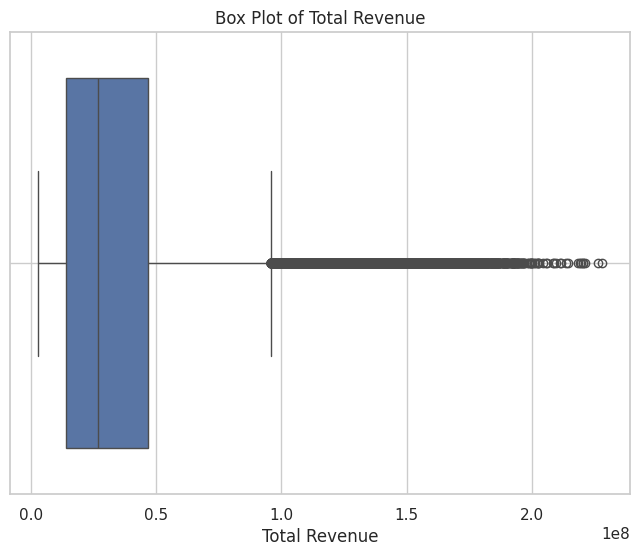

In [ ]:
sns.set(style="whitegrid")

# Box plot for 'Total Revenue' only
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['Total Revenue'])
plt.title('Box Plot of Total Revenue')
plt.xlabel('Total Revenue')
plt.grid(True)
plt.show()

In [ ]:
fig = px.histogram(df, x='Total Profit', nbins=1000, title="Distribution of Total Profit")
fig.show()

In [ ]:
fig = px.histogram(df, x='Units Sold', nbins=1000, title="Distribution of Units Sold")
fig.show()

In [ ]:
fig = px.box(df, x='Item Type', y='Units Sold', title='Units Sold per Item Type', color='Item Type', color_discrete_sequence=px.colors.qualitative.Set2)
fig.update_layout(showlegend=False)
fig.show()

In [ ]:
monthly_rev = df.groupby(pd.Grouper(key='Order Date', freq='ME'))['Units Sold'].sum().reset_index()
fig = px.line(monthly_rev, x='Order Date', y='Units Sold', title='Monthly Units Sold')
fig.show()

In [ ]:
region_units_sold = df.groupby('Region')['Units Sold'].sum().reset_index()

fig = px.bar(
    region_units_sold,
    x='Units Sold',
    y='Region',  # Switch axes for horizontal bars
    orientation='h',
    title='Units Sold by Region',
    color='Region',
    color_discrete_sequence=px.colors.qualitative.Set3
)

fig.update_layout(showlegend=False)
fig.show()


**Item Type vs. Profit**

In [ ]:
fig = px.box(df, x='Item Type', y='Total Profit', title='Profit Distribution by Item Type', color='Item Type', color_discrete_sequence=px.colors.qualitative.Set3)
fig.update_layout(showlegend=False)
fig.show()

**Correlation Heatmap**

In [ ]:
# Select only numeric features excluding 'Order ID'
numeric_df = df.drop(columns=['Order ID']).select_dtypes(include='number')

# Compute correlation
correlation_matrix = numeric_df.corr()

# Create heatmap
fig = px.imshow(
    correlation_matrix,
    text_auto=True,
    color_continuous_scale='Viridis',
    title="Correlation Heatmap (Excluding Order ID)"
)
fig.update_layout(showlegend=False)
fig.show()


**Sales Channel**

In [ ]:
fig = px.pie(
    df,
    names='Sales Channel',
    title='Sales Channel Distribution',
    color_discrete_sequence=px.colors.sequential.Plasma
)

# Show category labels directly on the pie slices
fig.update_traces(textinfo='label+percent', showlegend=False)

fig.show()

**Cost and Profit per Item Type**

In [ ]:
# Group the data
grouped = df.groupby('Item Type')[['Total Profit', 'Total Cost']].sum().reset_index()

# Create the figure with stacked bars
fig = go.Figure(data=[
    go.Bar(name='Total Cost', x=grouped['Item Type'], y=grouped['Total Cost'], marker_color='blue'),
    go.Bar(name='Total Profit', x=grouped['Item Type'], y=grouped['Total Profit'], marker_color='green')
])

# Update layout for stacking and aesthetics
fig.update_layout(
    barmode='stack',
    title='Cost and Profit per Item Type',
    xaxis_title='Item Type',
    yaxis_title='Amount ($)',
    xaxis_tickangle=45,
    legend_title=None,
    template='plotly_white'
)

fig.show()

**Units Sold Seasonality**

In [ ]:
# Extract month if not already done
df['Month'] = df['Order Date'].dt.month

# Group by Month and Item Type
monthly_sales = df.groupby(["Month", "Item Type"])["Units Sold"].mean().reset_index()

# Plot using Plotly
fig = px.line(
    monthly_sales,
    x="Month",
    y="Units Sold",
    color="Item Type",
    markers=True,
    title="Average Units Sold by Month (Seasonality)",
    labels={"Units Sold": "Average Units Sold", "Month": "Month"},
    color_discrete_sequence=px.colors.qualitative.Set2
)

# Optional: improve layout
fig.update_layout(
    xaxis=dict(dtick=1),
    template="plotly_white"
)

fig.show()

**Revenue and Profit per Unit**

In [ ]:
grouped = df.groupby('Item Type')[['Total Profit', 'Total Revenue','Total Cost','Units Sold']].sum()
grouped = grouped.sort_values('Total Revenue', ascending=False)

# Calculate Revenue and Profit per Unit
grouped['Revenue per Unit'] = grouped['Total Revenue'] / grouped['Units Sold']
grouped['Profit per Unit'] = grouped['Total Profit'] / grouped['Units Sold']

# Prepare data for Plotly
plot_data = grouped[['Profit per Unit','Revenue per Unit']].reset_index().melt(
    id_vars='Item Type',
    value_vars=['Profit per Unit','Revenue per Unit'],
    var_name='Metric',
    value_name='Amount'
)

# Plot with Plotly
fig = px.bar(
    plot_data,
    x='Amount',
    y='Item Type',
    color='Metric',
    orientation='h',
    barmode='group',
    title='Revenue and Profit per Unit by Item Type',
    labels={'Amount': 'Amount ($)', 'Item Type': 'Item Type'},
    color_discrete_sequence=px.colors.qualitative.Pastel
)

fig.update_layout(
    template="plotly_white",
    yaxis={'categoryorder':'total ascending'}  # Optional: sort bars
)

fig.show()

**Units Sold by Item Type**

In [ ]:
# Group by 'Item Type' and calculate total 'Units Sold'
item_type_units = df.groupby('Item Type')['Units Sold'].sum().sort_values(ascending=False).reset_index()

# Plot using Plotly
fig = px.bar(
    item_type_units,
    x='Units Sold',
    y='Item Type',
    orientation='h',
    color='Item Type',
    title='Units Sold by Item Type',
    color_discrete_sequence=px.colors.qualitative.Set3
)

# Optional: adjust x-axis range similar to seaborn min/max trick
min_limit = item_type_units['Units Sold'].min() * 0.9
max_limit = item_type_units['Units Sold'].max() * 1.01
fig.update_layout(
    xaxis_range=[min_limit, max_limit],
    showlegend=False,
    template='plotly_white'
)

fig.show()

**Leading Countries in Demand**

In [ ]:
# Get top 10 countries by total units sold
top_countries = df.groupby('Country')['Units Sold'].sum().nlargest(10).sort_values(ascending=False).reset_index()

# Create the horizontal bar chart
fig = px.bar(
    top_countries,
    x='Units Sold',
    y='Country',
    orientation='h',
    color='Country',
    title='Top 10 Countries by Units Sold',
    color_discrete_sequence=px.colors.sequential.Viridis
)

# Adjust x-axis limits like seaborn example
min_limit = top_countries['Units Sold'].min() * 0.9
max_limit = top_countries['Units Sold'].max() * 1.01
fig.update_layout(
    xaxis_range=[min_limit, max_limit],
    showlegend=False,
    template='plotly_white'
)

fig.show()

**Profit by Region**

In [ ]:
# Group and sum
demand_by_region = df.groupby('Region')['Units Sold'].sum().reset_index()

# Create Plotly pie chart with labels on the slices
fig = px.pie(
    demand_by_region,
    names='Region',
    values='Units Sold',
    title='Total Profit by Region',
    color_discrete_sequence=px.colors.qualitative.Set3,  # Optional: match Seaborn palette
    hole=0  # Set to >0 if you want a donut chart
)

# Show percentage labels on the chart slices, not in legend
fig.update_traces(textinfo='label+percent', textposition='outside', showlegend=False)
fig.update_layout(title_x=0.5)  # Center the title

fig.show()

In [ ]:
fig = px.scatter(df, x="Units Sold", y="Total Profit", color="Item Type",
                 title="Profit vs. Units Sold by Item Type", color_discrete_sequence=px.colors.qualitative.Set3)

# Show the plot
fig.show()

In [ ]:
df_temp = df.copy()

# Ensure 'Order Date' is datetime and set it as the index
df_temp['Order Date'] = pd.to_datetime(df_temp['Order Date'])
df_temp.set_index('Order Date', inplace=True)

# Now resample monthly
monthly_demand = df_temp['Units Sold'].resample('ME').sum()
rolling_avg = monthly_demand.rolling(window=3).mean()

# Create base figure
fig = go.Figure()

# Monthly Demand line
fig.add_trace(go.Scatter(
    x=monthly_demand.index,
    y=monthly_demand.values,
    mode='lines+markers',
    name='Monthly Demand',
    line=dict(color='blue'),
    marker=dict(symbol='circle')
))

# Rolling average line
fig.add_trace(go.Scatter(
    x=rolling_avg.index,
    y=rolling_avg.values,
    mode='lines',
    name='Rolling Avg (3-month)',
    line=dict(color='orange', width=3)
))

# Add seasonal shading: Summer (June to August) and Winter (Dec to Feb)
years = monthly_demand.index.year.unique()
for year in years:
    # Summer shading
    fig.add_vrect(
        x0=f'{year}-06-01', x1=f'{year}-08-31',
        fillcolor='skyblue', opacity=0.1, line_width=0
    )
    # Winter shading (Dec to Feb next year)
    fig.add_vrect(
        x0=f'{year}-12-01', x1=f'{year+1}-02-28',
        fillcolor='lightgray', opacity=0.15, line_width=0
    )

# Annotate minimum demand (February)
min_month = monthly_demand.idxmin()
min_value = monthly_demand.min()

fig.add_annotation(
    x=min_month,
    y=min_value,
    text='February has the lowest demand<br>across the years',
    showarrow=True,
    arrowhead=2,
    arrowcolor='red',
    font=dict(color='red', size=12),
    yshift=60
)

# Final layout
fig.update_layout(
    title='Monthly Demand with Rolling Average and Seasonal Shading',
    xaxis_title='Month',
    yaxis_title='Units Sold',
    template='plotly_white',
    xaxis=dict(tickformat='%b %Y'),
    margin=dict(t=50, l=50, r=30, b=80),
    showlegend=True,
    legend=dict(x=0.01, y=0.99)
)

fig.show()

In [ ]:
fig = px.box(
    df,
    x='Item Type',
    y='Shipping_Days',
    color='Item Type',
    title='Shipping Delay by Item Type',
    color_discrete_sequence=px.colors.qualitative.Set2
)

# Improve layout and spacing
fig.update_layout(
    xaxis_title='Item Type',
    yaxis_title='Shipping Delay (days)',
    xaxis_tickangle=45,
    showlegend=False,
    template='plotly_white',
    margin=dict(t=50, l=50, r=30, b=100)
)

fig.show()

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=dff['Order Date'], y=dff['Units Sold'],
    mode='lines', name='Units Sold'
))

fig.add_trace(go.Scatter(
    x=dff['Order Date'], y=dff['Rolling_30d_Avg_Units'],
    mode='lines', name='30d Rolling Avg', line=dict(dash='dash')
))

fig.update_layout(
    title='Units Sold Over Time',
    xaxis_title='Order Date',
    yaxis_title='Units Sold',
    template='plotly_white'
)

fig.show()

In [ ]:
region_units = dff.groupby('Region')['Units Sold'].sum().reset_index()

fig = px.bar(region_units, x='Region', y='Units Sold',
             title='Total Units Sold by Region for Fruits',
             color='Units Sold',
             template='plotly_white')

fig.show()

In [ ]:
region_uni = dfv.groupby('Region')['Units Sold'].sum().reset_index()

fig = px.bar(region_uni, x='Region', y='Units Sold',
             title='Total Units Sold by Region for Vegetables',
             color='Units Sold',
             template='plotly_dark')

fig.show()

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=dfp['Order Date'], y=dfp['Units Sold'],
    mode='lines', name='Units Sold'
))

fig.add_trace(go.Scatter(
    x=dfp['Order Date'], y=dfp['Rolling_30d_Avg_Units'],
    mode='lines', name='30d Rolling Avg', line=dict(dash='dash')
))

fig.update_layout(
    title='Units Sold Over Time for personal care',
    xaxis_title='Order Date',
    yaxis_title='Units Sold',
    template='plotly_white'
)

fig.show()

In [ ]:
fig = px.density_heatmap(dfp, x='DayOfWeek', y='WeekOfYear', z='Units Sold',
                         title='Weekly Sales Pattern', nbinsx=7, nbinsy=52,text_auto=True, color_continuous_scale='Viridis')
fig.show()

In [ ]:
fig = px.bar(dfp, x='Sales Channel', y='Total Profit', color='Sales Channel',
             title='Profit by Sales Channel', barmode='group')
fig.show()
